  # ASETS-II cases simulation

  This is an example of a simulation package for conjugate heat transfer of an
  oscillating heat pipe. SI units are used and units are emitted

  ### What do we need to solve an OHP problem?

  **specify properties** : Solid property, Fluid property

  **set the geometries** : Computational domain, Heaters/Condensers, OHP shapes

  **construct the systems** : Fluid system(1D), HeatConduction system(2D)

  **initialize** : initialize the integrators and the data structs for saving

  **solve** : time marching to solve the two weakly coupled integrators
  alternately

  **save/examine** : save the data for post-processing

  # Packages

  Firstly, let's import the necessary packages, you may need to install them
  for the first time.

In [326]:
using OscillatingHeatPipe # our main package
using Plots # for plotting
using ProgressMeter # to have a progress bar in the calculation

  # Specify properties

  ### Solid Physical parameters

  params is the HeatConductionParameters for the plate material. The numbers
  below represents aluminum.

In [327]:
ρₛ = 2730; # material density [kg/m^3]
cₛ  = 8.93e02; # material specific heat [J/kg K]
kₛ  = 1.93e02; # material heat conductivity
αₛ = kₛ/ρₛ/cₛ

dₛ = 1.5e-3; # effective d (The thickness of an ideal uniform thickness plate occupying the same volume)

  ### Fluid Physical parameters

  pfluid contains the vapor and liquid properties at a constant reference
  temperature. Noted that the vapor pressure and the vapor density will be
  functions of temperatures during the simulation, other properties are
  extracted from pfluid as an approximate value.

In [328]:
Tref = 291.2 # reference temperature
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref) # This function relies on CoolProp.jl package

Saturation properties for Butane at constant temperature 291.2 [K]


  # Set the geometries

  ### Geometry parameters

  The 2D domain is of rectangular shape (slightly different from ASETS-II). In
  the future it can be of arbitrary shape using the immersedlayers.jl package.

In [329]:
Δx = 0.0007 # [m]

Lx = 6*INCHES*1.02; # plate size x [m]
Ly = 2*INCHES*1.05; # plate size y [m]
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits

g = PhysicalGrid(1.03 .* xlim,1.1 .* ylim,Δx); # build a gird slightly larger than the plate

## set physical parameters

In [330]:
power = 70 # Watt
areaheater_area = 12e-3 * 12e-3

0.000144

In [331]:
phys_params = Dict( "diffusivity"              => αₛ,
                    "flux_correction"          => ρₛ*cₛ*dₛ,
                    # "angular velocity"         => 0.0,
                    "Fourier"                  => 1.0,
                    "ohp_flux"                 => [NaN], # initial value, the value here is useless
                    "areaheater_power"         => power, # total power
                    "areaheater_area"          => areaheater_area, # total area
                    "areaheater_temp"          => 0.0,   # relative temperature compared with "background temperature"
                    "areaheater_coeff"         => 5000.0,
                    "adiabatic_coeff"          => 0.0,
                    "background temperature"   => Tref
                     )
     

Dict{String, Any} with 10 entries:
  "areaheater_coeff"       => 5000.0
  "Fourier"                => 1.0
  "flux_correction"        => 3656.84
  "ohp_flux"               => [NaN]
  "diffusivity"            => 7.91668e-5
  "areaheater_area"        => 0.000144
  "areaheater_power"       => 70
  "areaheater_temp"        => 0.0
  "adiabatic_coeff"        => 0.0
  "background temperature" => 291.2

## Boundary conditions

In [332]:
Δs = 1.4*cellsize(g)

trim = 0.006
cond_block = 1.1INCHES
# xbound = [ -Lx/2,-Lx/2, -Lx/2+cond_block,-Lx/2+cond_block, Lx/2-cond_block,  Lx/2-cond_block, 
#             Lx/2, Lx/2,  Lx/2-cond_block, Lx/2-cond_block,-Lx/2+cond_block, -Lx/2+cond_block];
# ybound = [  Ly/2,-Ly/2, -Ly/2,           -Ly/2+trim,      -Ly/2+trim,       -Ly/2, 
#            -Ly/2, Ly/2,  Ly/2,            Ly/2-trim ,      Ly/2-trim,        Ly/2 ];
xbound = [ -Lx/2,-Lx/2, 
            Lx/2, Lx/2];
ybound = [  Ly/2,-Ly/2, 
           -Ly/2, Ly/2];
body = Polygon(xbound,ybound,Δs)

Closed polygon with 4 vertices and 426 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


In [333]:
X = MotionTransform([0,0],0)
joint = Joint(X)
m = RigidBodyMotion(joint,body)
x = zero_motion_state(body,m)
update_body!(body,x,m)

Closed polygon with 4 vertices and 426 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


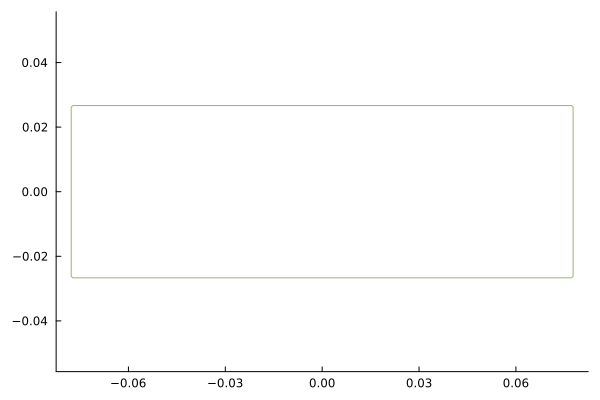

In [334]:
plot(body,fillalpha=0)

In [335]:
function get_qbplus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbplus = zeros_surface(base_cache)
    return qbplus
end

function get_qbminus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbminus = zeros_surface(base_cache)
    # qbminus .= nrm.u
    return qbminus
end

bcdict = Dict("exterior" => get_qbplus,"interior" => get_qbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_qbminus
  "exterior" => get_qbplus

  ### Set up the evaporators and condensers

  Right now, the OHPtype looks up a preset dictionary of OHP evaporators and
  condensers.

  You can also customize them in the OHP DIY notebook

In [336]:
function heatermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    σ .= phys_params["areaheater_power"] / phys_params["areaheater_area"] / phys_params["flux_correction"] 
end


function condensermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    T0 = phys_params["areaheater_temp"]
    h = phys_params["areaheater_coeff"]
    corr = phys_params["flux_correction"] 

    σ .= h*(T0 - T) / corr
end

function adiabaticmodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    T0 = phys_params["areaheater_temp"]
    h = phys_params["adiabatic_coeff"]
    corr = phys_params["flux_correction"] 

    σ .= h*(T0 - T)/ corr
end

adiabaticmodel! (generic function with 1 method)

In [337]:
fregion1_h = Rectangle(12.5e-3,25e-3,1.4*Δx)
# fregion2_h = deepcopy(fregion1_h)
tr1_h = RigidTransform((0.0,-0.0),0.0)
# tr2_h = RigidTransform((-25e-3,-0.0),0.0)

heater1 = AreaForcingModel(fregion1_h,tr1_h,heatermodel!);
# heater2 = AreaForcingModel(fregion2_h,tr2_h,heatermodel!);

In [338]:
fregion1_c = Rectangle(7.5e-3,1.0INCHES,1.4*Δx)
tr1_c = RigidTransform((2.7INCHES,-0.0),0.0)
fregion2_c = deepcopy(fregion1_c)
# tr1_c = RigidTransform((2.7INCHES,-0.0),0.0)
tr2_c = RigidTransform((-2.7INCHES,-0.0),0.0)

cond1 = AreaForcingModel(fregion1_c,tr1_c,condensermodel!);
cond2 = AreaForcingModel(fregion2_c,tr2_c,adiabaticmodel!);

  ### Set up OHP channel's shape

  constructohpcurve is a built-in function that generates two arrays: x that
  contains all x values of the discrete points, and y contains all y values. x
  and y have the same length.

  You can also customize this function to generate an OHP shape of your choice
  as long as they produce x array and y array.

In [339]:
# x, y = construct_ohp_curve("ASETS",Δx) # get x and y coordinates for the channel
        ds = 1.5Δx
        nturn = 16
        width_ohp = 46.25*1e-3
        length_ohp = 147.0*1e-3
        gap = 3e-3
        pitch = width_ohp/(2*nturn+1)
        x0, y0 = length_ohp/2 +2e-3, width_ohp/2

    x, y, xf, yf = construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,3pi/2)
    
ohp = BasicBody(x,y) # build a BasicBody based on x,y

# fregion1 = Square(0.5,1.4*Δx)
tr_ohp = RigidTransform((0.0,0.0),0.0)

# phys_params["ohp_flux"] = zero(x);

function ohpmodel!(σ,T,t,fr::LineRegionCache,phys_params)
    σ .= phys_params["ohp_flux"] ./ phys_params["flux_correction"] * 0.0
end
ohp_linesource = LineForcingModel(ohp,tr_ohp,ohpmodel!);

  ### Plot what you got so far

  This is a exmaple of the compuational domain (the box) and the OHP channel
  serpentine (in blue)

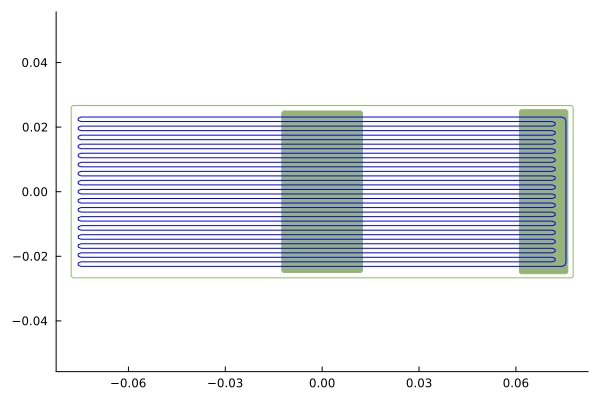

In [340]:
plot(body,fillalpha=0)
update_body!(fregion1_h,tr1_h)
# update_body!(fregion2_h,tr2_h)
update_body!(fregion1_c,tr1_c)
update_body!(fregion2_c,tr2_c)
# update_body!(fregion3,tr3)
# update_body!(fregion4,tr4)
plot!(fregion1_h)
plot!(fregion1_c)
# plot!(fregion2_h)
# plot!(fregion2_c)
# plot!(fregion2)
# plot!(fregion3)
# plot!(fregion4)
plot!(ohp,fillalpha=0,closedornot=true)

In [341]:
# forcing_dict = Dict("heating models" => [heater1,cond1,ohp_linesource])
# forcing_dict = Dict("heating models" => [heater1,cond1,cond2,ohp_linesource])
forcing_dict = Dict("heating models" => [heater1,cond1,cond2])

Dict{String, Vector{AreaForcingModel{RT, MotionTransform{2}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}} where RT}} with 1 entry:
  "heating models" => [AreaForcingModel{Polygon{154, 4, ClosedBody}, MotionTran…

In [342]:
tspan = (0.0, 100.0); # start time and end time
dt_record = 1.0   # saving time interval

tstep = 5e-2     # actrual time marching step

0.05

In [343]:
timestep_fixed(u,sys) = tstep

timestep_fixed (generic function with 1 method)

In [344]:
prob = NeumannHeatConductionProblem(g,body,scaling=GridScaling,
                                             phys_params=phys_params,
                                             bc=bcdict,
                                             motions=m,
                                             forcing=forcing_dict,
                                             # timestep_func=timestep_fourier
                                             timestep_func=timestep_fixed
    );

  # Construct the systems

  ### Create HeatConduction system

  The solid module dealing with the 2D conduction, evaporator, condenser, and
  the OHP line heat source is constructed here.

In [345]:
sys_plate = construct_system(prob);

  # Initialize

  ### set time step

  ### combine inner tube and plate together

In [346]:
tspan_init = (0.0,1e4) # for plate, should be a range larger than the TOTAL time you plan to simulate (including saving and re-run),
# if the range is smaller than the total time range, there will be errors in temperature interpolations

u_plate = init_sol(sys_plate)# initialize plate T field to uniform Tref
integrator_plate = init(u_plate,tspan_init,sys_plate,save_on=false) # construct integrator_plate

t: 0.0
u: (Primal nodes in a (nx = 240, ny = 90) cell grid of type Float64 data
  Number of Primal nodes: (nx = 239, ny = 89), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

[ Info: Saved animation to /Users/yuxuanli/Documents/GitHub/OscillatingHeatPipe/examples/tmp.gif


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/OscillatingHeatPipe/examples/tmp.gif")
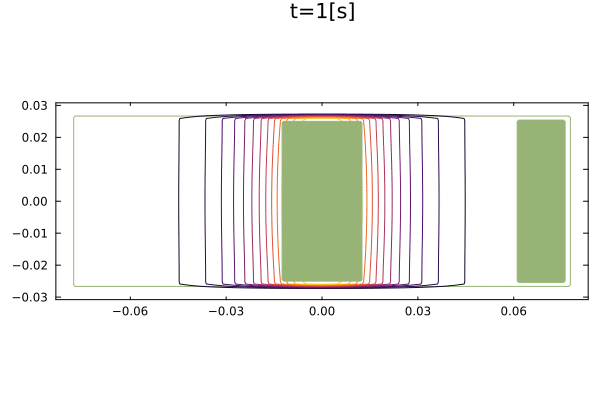

In [347]:
@gif for i = 1:300
    step!(integrator_plate,4.0,true)
    grid = integrator_plate.p.base_cache.g
    plot(body,fillalpha=0)
    plot!(temperature(integrator_plate),grid)
    plot!(fregion1_h)
    plot!(fregion1_c,title=string("t=",i,"[s]"))
end

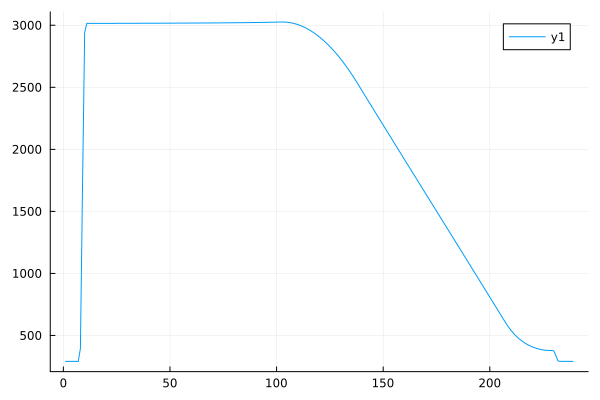

In [349]:
plot(temperature(integrator_plate)[:,45])